# Certified Training using Zonotopes with DeepZ

In this notebook we will look at how different training strategies impact the certified performance, and see that by using certified training very high levels of certification can be obtained. 

The drawback is that using certified training is computatianally expensive, even when compared to PGD adversarial training.

The zonotopes abstraction used here is defined by:
\begin{equation}
    \hat{x} = \eta_0 + \sum_{i=1}^{i=N} \eta_i \epsilon_i 
\end{equation}

where $\eta_0$ is the central vector, $\epsilon_i$ are noise symbols, $\eta_i$ are coefficients representing deviations around $\eta_0$.

By pushing zonotopes through a neural network we can obatin an overapproximation of the worst case loss and optimise the weights for certifiable robustness.

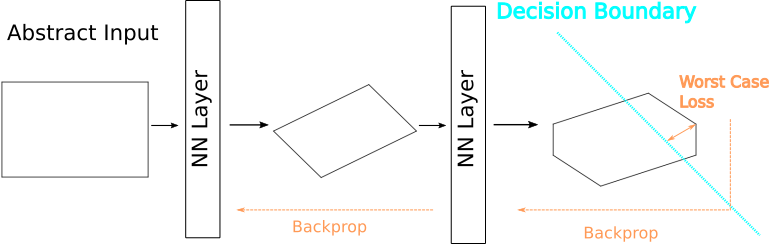

In [1]:
import os

import torch
import torch.optim as optim
import numpy as np

from torch import nn
from sklearn.utils import shuffle

from art.estimators.certification import deep_z
from art.utils import load_mnist, preprocess, to_categorical

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if not os.path.isdir('notebook_models/mnist/certified/'):
    os.makedirs('notebook_models/mnist/certified/') 

if not os.path.isdir('notebook_models/mnist/pgd/'):
    os.makedirs('notebook_models/mnist/pgd/')

/home/giulio/Documents/Projects/certified_training_art/venv/lib64/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# For all of the demonstrations we will use this example MNIST model.

class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=16,
                               kernel_size=(4, 4),
                               dilation=(1, 1),
                               padding=(0, 0),
                               stride=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               dilation=(1, 1),
                               padding=(0, 0),
                               kernel_size=(4, 4),
                               stride=(2, 2))
        self.fc1 = nn.Linear(in_features=800,
                             out_features=1000)
        self.fc2 = nn.Linear(in_features=1000,
                             out_features=10)
        self.relu = nn.ReLU()


    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float().to(device)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
model = MNISTModel()
model = model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

x_test = np.squeeze(x_test)
x_test = np.expand_dims(x_test, axis=1)
y_test = np.argmax(y_test, axis=1)

x_train = np.squeeze(x_train)
x_train = np.expand_dims(x_train, axis=1)
y_train = np.argmax(y_train, axis=1)

In [4]:
# train the model normally

def standard_train(model, opt, criterion, x, y, bsize=32, epochs=5):
    num_of_batches = int(len(x) / bsize)
    for epoch in range(epochs):
        x, y = shuffle(x, y)
        loss_list = []
        for bnum in range(num_of_batches):
            x_batch = np.copy(x[bnum * bsize:(bnum + 1) * bsize])
            y_batch = np.copy(y[bnum * bsize:(bnum + 1) * bsize])

            x_batch = torch.from_numpy(x_batch).float().to(device)
            y_batch = torch.from_numpy(y_batch).type(torch.LongTensor).to(device)

            # zero the parameter gradients
            opt.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss_list.append(loss.data.cpu().detach().numpy())
            loss.backward()
            opt.step()
        print('End of epoch {} loss {}'.format(epoch, np.mean(loss_list)))
    return model

model = standard_train(model=model,
                       opt=opt,
                       criterion=criterion,
                       x=x_train,
                       y=y_train)

End of epoch 0 loss 0.4505019783973694
End of epoch 1 loss 0.14715342223644257
End of epoch 2 loss 0.08925174176692963
End of epoch 3 loss 0.06519503891468048
End of epoch 4 loss 0.052043616771698


In [5]:
# lets now get the predicions for the MNIST test set and see how well our model is doing.
with torch.no_grad():
    test_preds = model(torch.from_numpy(x_test).float().to(device))

test_preds = np.argmax(test_preds.cpu().detach().numpy(), axis=1)
print('Test acc: ', np.mean(test_preds == y_test) * 100)

Test acc:  98.36


In [6]:
# But how robust are these predictions? 
# We can now examine this neural network's certified robustness. 
# We pass it into PytorchDeepZ. We will get a print out showing which 
# neural network layers have been registered. There will also be a 
# warning to tell us that PytorchDeepZ currently infers a reshape when 
# a neural network goes from using convolutional to dense layers. 
# This will cover the majority of use cases, however, if not then the 
# certification layers in art.estimators.certification.deepz.deep_z.py 
# can be used to directly build a certified model structure.

zonotope_model = deep_z.PytorchDeepZ(model=model, 
                                     clip_values=(0, 1),
                                     optimizer = optim.Adam(model.parameters(), lr=1e-4),
                                     loss=nn.CrossEntropyLoss(), 
                                     input_shape=(1, 28, 28), 
                                     nb_classes=10)

registered <class 'torch.nn.modules.conv.Conv2d'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.conv.Conv2d'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.linear.Linear'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.linear.Linear'>
Inferred reshape on op num 4


/home/giulio/Documents/Projects/certified_training_art/adversarial-robustness-toolbox/art/estimators/certification/deep_z/pytorch.py:239: UserWarning: 
This estimator does not support networks which have dense layers before convolutional. We currently infer a reshape when a neural network goes from convolutional layers to dense layers. If your use case does not fall into this pattern then consider directly building a certifier network with the custom layers found in art.estimators.certification.deepz.deep_z.py

  warnings.warn(


In [7]:
# Lets now see how robust our model is!
# First we need to define what bound we need to check. 
# Here let's check for L infinity robustness with small bound of 0.15

# lets now loop over the data to check its certified robustness:
# we need to consider a single sample at a time as due to memory and compute footprints batching is not supported.
# In this demo we will look at the first 50 samples of the MNIST test data.

original_x = np.copy(x_test)
def certification_loop(model, x, y, preds, bound):
    num_certified = 0
    num_correct = 0
    for i, (sample, pred, label) in enumerate(zip(x[:50], preds[:50], y[:50])):

        # we make the matrix representing the allowable perturbations. 
        # we have 28*28 features and each one can be manipulated independently requiring a different row.
        # hence a 784*784 matrix.
        eps_bound = np.eye(784) * bound

        # we then need to adjust the raw data with the eps bounds to take into account
        # the allowable range of 0 - 1 for pixel data.
        # We provide a simple function to do this preprocessing for image data.
        # However if your use case is not supported then a custom pre-processor function will need to be written.
        sample, eps_bound = model.pre_process(cent=sample, 
                                              eps=eps_bound)
        sample = np.expand_dims(sample, axis=0)

        # We pass the data sample and the eps bound to the certifier along with the prediction that was made
        # for the datapoint. 
        # A boolean is returned signifying if it can have its class changed under the given bound.
        is_certified = model.certify(cent=sample,
                                     eps=eps_bound,
                                     prediction=pred)

        if pred == label:
            num_correct +=1
            if is_certified:
                num_certified +=1 

        print('Classified Correct {}/{} and also certified {}/{}'.format(num_correct, i+1, num_certified, i+1))

In [8]:
# We can toggle how zonotope_model will process data though the method set_forward_mode.
# with 'abstract' it will use abstract operations on the input (which is expected to be a zonotope).
# with 'concrete' the nerual network will be run normally and expects regular data as input.

# As we want to do certification analysis now, lets set the model to run in abstract mode

zonotope_model.model.set_forward_mode('abstract')
certification_loop(model=zonotope_model,
                   x=np.copy(x_test),
                   y=y_test,
                   preds=test_preds,
                   bound=0.15)

Classified Correct 1/1 and also certified 0/1
Classified Correct 2/2 and also certified 0/2
Classified Correct 3/3 and also certified 0/3
Classified Correct 4/4 and also certified 0/4
Classified Correct 5/5 and also certified 0/5
Classified Correct 6/6 and also certified 0/6
Classified Correct 7/7 and also certified 0/7
Classified Correct 8/8 and also certified 0/8
Classified Correct 9/9 and also certified 0/9
Classified Correct 10/10 and also certified 0/10
Classified Correct 11/11 and also certified 0/11
Classified Correct 12/12 and also certified 0/12
Classified Correct 13/13 and also certified 0/13
Classified Correct 14/14 and also certified 0/14
Classified Correct 15/15 and also certified 0/15
Classified Correct 16/16 and also certified 0/16
Classified Correct 17/17 and also certified 0/17
Classified Correct 18/18 and also certified 0/18
Classified Correct 19/19 and also certified 0/19
Classified Correct 20/20 and also certified 0/20
Classified Correct 21/21 and also certified 0/2

We can see that our NN has a very low certified robustness. You can modify the `bound` parameter in the function `certification_loop` to see how the certfied robustness varies. We can now try and improve this through different robust training stratgies. We will look at:

+ Using certified adversarial training
+ Using PGD adversarial training.

In [9]:
from art.defences.trainer import AdversarialTrainerCertifiedPytorch

# We will now train the model to improve its certified accuracy. 
# Regular PGD training will boost certified performance, however even higher certification scores can 
# be obtained by training the nerual network with the objective of certified performance. Let's compare the 
# two methods.

# NB! Certified Adversarial training takes about 9 hours on an NVIDIA V100 with the following parameters.

pgd_params = {"eps": 0.3,
              "eps_step": 0.05,
              "max_iter": 20,
              "num_random_init": 1,
              "batch_size": 32,}

trainer = AdversarialTrainerCertifiedPytorch(zonotope_model,
                                             pgd_params=pgd_params,
                                             batch_size=10,
                                             bound=0.15)

# Uncomment if you wish to train your own model, but it will take several hours!

#trainer.fit(x_train,
#            y_train,
#            nb_epochs=30)
# torch.save(trainer._classifier.model.state_dict(), 'notebook_models/mnist/certified/model.pt')

# Here we will load a model which was trained using the above function.
trainer._classifier.model.load_state_dict(torch.load('notebook_models/mnist/certified/model.pt', map_location=torch.device(device)))

<All keys matched successfully>

In [10]:
# Like before we obtain the model's test time accuracy
# Make sure to set the model in concrete forward mode

with torch.no_grad():
    trainer._classifier.model.set_forward_mode('concrete')
    test_preds = model(torch.from_numpy(x_test).float().to(device))

test_preds = np.argmax(test_preds.cpu().detach().numpy(), axis=1)
print('Test acc: ', np.mean(test_preds == y_test) * 100)

Test acc:  98.7


In [11]:
# then let's compare the certified robustness using certified training against the 
# model that was trained regularly. We will see that the model now has extremly high certified robustness.

trainer._classifier.model.set_forward_mode('abstract')
certification_loop(model=trainer._classifier,
                   x=np.copy(x_test),
                   y=y_test,
                   preds=test_preds,
                   bound=0.15)

Classified Correct 1/1 and also certified 1/1
Classified Correct 2/2 and also certified 2/2
Classified Correct 3/3 and also certified 3/3
Classified Correct 4/4 and also certified 4/4
Classified Correct 5/5 and also certified 5/5
Classified Correct 6/6 and also certified 6/6
Classified Correct 7/7 and also certified 7/7
Classified Correct 8/8 and also certified 8/8
Classified Correct 9/9 and also certified 8/9
Classified Correct 10/10 and also certified 9/10
Classified Correct 11/11 and also certified 10/11
Classified Correct 12/12 and also certified 11/12
Classified Correct 13/13 and also certified 12/13
Classified Correct 14/14 and also certified 13/14
Classified Correct 15/15 and also certified 14/15
Classified Correct 16/16 and also certified 15/16
Classified Correct 17/17 and also certified 16/17
Classified Correct 18/18 and also certified 17/18
Classified Correct 19/19 and also certified 17/19
Classified Correct 20/20 and also certified 18/20
Classified Correct 21/21 and also cer

In [12]:
# For the final comparison, we will look at how PGD trainng compares. 
# Let's make a new model and train it using art's AdversarialTrainer 

from art.attacks.evasion.projected_gradient_descent.projected_gradient_descent import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from art.defences.trainer import AdversarialTrainer

pgd_params = {"eps": 0.3,
              "eps_step": 0.01,
              "max_iter": 30,
              "batch_size": 32,
              "num_random_init": 1}

model = MNISTModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

attack = ProjectedGradientDescent(
    estimator=classifier,
    eps=pgd_params["eps"],
    eps_step=pgd_params["eps_step"],
    max_iter=pgd_params["max_iter"],
    num_random_init=pgd_params["num_random_init"],
)

trainer = AdversarialTrainer(classifier, attack, ratio=1.0)

# Uncomment if you wish to train your own pdg model, but it may take 30min to ~2 hours depending 
# on your hardware.

# trainer.fit(x_train, y_train, nb_epochs=20, batch_size=32)
# torch.save(trainer._classifier.model.state_dict(), 'notebook_models/mnist/certified/pgd_model.pt')

# Here we will load a model which was trained using the above function.
trainer._classifier.model.load_state_dict(torch.load('notebook_models/mnist/pgd/pgd_model.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
# Let's get the model we trained with PGD and pass it into PytorchDeepZ so we can use 
# the certification methods on the model

zonotope_model = deep_z.PytorchDeepZ(model=trainer._classifier.model, 
                                     clip_values=(0, 1),
                                     optimizer = optim.Adam(model.parameters(), lr=1e-4),
                                     loss=nn.CrossEntropyLoss(), 
                                     input_shape=(1, 28, 28), 
                                     nb_classes=10)

# Get the test time predictions. As always, set the forward_mode to the correct type
with torch.no_grad():
    zonotope_model.model.set_forward_mode('concrete')
    test_preds = zonotope_model.model.forward(torch.from_numpy(x_test).float().to(device))

test_preds = np.argmax(test_preds.cpu().detach().numpy(), axis=1)
print('Test acc: ', np.mean(test_preds == y_test) * 100)


registered <class 'torch.nn.modules.conv.Conv2d'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.conv.Conv2d'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.linear.Linear'>
registered <class 'torch.nn.modules.activation.ReLU'>
registered <class 'torch.nn.modules.linear.Linear'>
Inferred reshape on op num 4
Test acc:  98.67


In [14]:
# And finally, lets see the PGD model's certified robustness.

# We set the appropriate forward mode
zonotope_model.model.set_forward_mode('abstract')

# And then run the certification. We see that although PGD trainig boosts the certified robustness
# in comparison to normal training, it's performance is much weaker than certified training.
certification_loop(model=zonotope_model,
                   x=np.copy(x_test),
                   y=y_test,
                   preds=test_preds,
                   bound=0.15)

Classified Correct 1/1 and also certified 1/1
Classified Correct 2/2 and also certified 2/2
Classified Correct 3/3 and also certified 3/3
Classified Correct 4/4 and also certified 3/4
Classified Correct 5/5 and also certified 3/5
Classified Correct 6/6 and also certified 4/6
Classified Correct 7/7 and also certified 4/7
Classified Correct 8/8 and also certified 4/8
Classified Correct 9/9 and also certified 4/9
Classified Correct 10/10 and also certified 4/10
Classified Correct 11/11 and also certified 5/11
Classified Correct 12/12 and also certified 5/12
Classified Correct 13/13 and also certified 5/13
Classified Correct 14/14 and also certified 6/14
Classified Correct 15/15 and also certified 7/15
Classified Correct 16/16 and also certified 7/16
Classified Correct 17/17 and also certified 7/17
Classified Correct 18/18 and also certified 8/18
Classified Correct 19/19 and also certified 8/19
Classified Correct 20/20 and also certified 9/20
Classified Correct 21/21 and also certified 9/2